In [0]:

%pip install -qqqq langchain-mcp-adapters mcp databricks-langchain langgraph langchain mlflow python-dotenv pydantic databricks-agents unitycatalog-langchain[databricks] uv
%restart_python

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from key import *

In [0]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from databricks_langchain import ChatDatabricks
from databricks.sdk import WorkspaceClient
import mlflow

import os

from dotenv import load_dotenv

mlflow.langchain.autolog()

load_dotenv()

w = WorkspaceClient()

os.environ["DATABRICKS_HOST"] = w.config.host
os.environ["DATABRICKS_TOKEN"] = w.tokens.create(comment="for model serving", lifetime_seconds=1200).token_value

llm = ChatDatabricks(endpoint="databricks-meta-llama-3-3-70b-instruct")


client = MultiServerMCPClient({
    "nimble": {
        "url": "https://mcp.nimbleway.com/sse",
        "transport": "sse",
        "headers": {
            "Authorization": f"Bearer {NIMBLE_KEY}"
        }
    }
})

tools = await client.get_tools()
# flight_agent = create_react_agent(llm, tools, prompt="""
#         You are a flight agent. You are responsible for finding the best flights for the accessible or disable person. Analyze the user's requirements and the tool response and return a few of the best flight information.
#     """)

In [0]:
flight_agent_prompt =  """You are a specialized flight booking assistant for travelers with accessibility needs.
Your goals:
- Always recommend **non-stop round-trip flights**.
- Include **flight numbers, airline names, departure/arrival times, and airports**.
- Include **multiple cabin options** (Economy, Premium Economy, Business) with costs and accessibility benefits.
- Provide details on **wheelchair boarding assistance**, **pre-boarding**, and **in-flight services for accessible travelers**.
- Mention **total cost breakdown** (ticket + taxes + fees).
- Prioritize **morning departures**, **non-stop routes**, and major carriers.
Example output:
- American Airlines Flight 234: Departs BOS at 8:00 AM, arrives SAN at 11:35 AM. Wheelchair assistance available, priority boarding included. Economy: $525, Premium: $745.
ALWAYS USE TOOLS. DO NOT RESPOND DIRECTLY. Give Detailed output. Do not skip anything
    """
flight_agent = create_react_agent(llm, tools, prompt=flight_agent_prompt)

lodging_agent_prompt =  """You are a specialized hotel search assistant for travelers with disabilities.
Your goals:
- Always return **2–3 hotels** with full accessibility.
- Include **room types** (roll-in shower, grab bars, lowered counters, visual fire alarms).
- Include **hotel location** (how far from major landmarks or airports).
- Include **amenities**: elevators, Braille signage, assistive listening devices, accessible pool, ADA shuttles.
- Show **nightly rate**, **total cost**, **star rating**, and **guest accessibility reviews**.
- Emphasize best pick based on **proximity**, **cost**, and **accessibility score**.
Example output:
- Hyatt Regency San Diego: 4-star hotel, 10 min from airport, $225/night. Features include roll-in showers, elevators, hearing aids, and ADA shuttles.
ALWAYS USE TOOLS. DO NOT RESPOND DIRECTLY.  Give Detailed output. Do no skip anything.
    """
lodging_agent = create_react_agent(llm, tools, prompt=lodging_agent_prompt)

In [0]:
import functools
import os
from typing import Any, Generator, Literal, Optional

import mlflow
from databricks.sdk import WorkspaceClient
from databricks_langchain import (
    ChatDatabricks,
    UCFunctionToolkit,
)
from databricks_langchain.genie import GenieAgent
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import create_react_agent
from mlflow.langchain.chat_agent_langgraph import ChatAgentState
from mlflow.pyfunc import ChatAgent
from mlflow.types.agent import (
    ChatAgentChunk,
    ChatAgentMessage,
    ChatAgentResponse,
    ChatContext,
)
from pydantic import BaseModel

In [0]:

# LLM_ENDPOINT_NAME = "databricks-meta-llama-3-3-70b-instruct"
# llm = ChatDatabricks(endpoint=LLM_ENDPOINT_NAME)

# flight_agent_description = (
#     "THe flight agent will fetch all flight information for you. Always ask for infromation considering asking person is either accessible or disable person. DO NOT USE DEEP SEARCH",
# )
# lodging_agent_description = (
#     "THe flight agent will fetch all lodging or hotel information for you. Always ask for infromation considering asking person is either accessible or disable person. DO NOT USE DEEP SEARCH",
# )
# # TODO update the max number of iterations between supervisor and worker nodes
# # before returning to the user
# MAX_ITERATIONS = 3

# worker_descriptions = {
#     "Flight-Agent": flight_agent_description,
#     "Lodging-Agent": lodging_agent_description,
# }

# formatted_descriptions = "\n".join(
#     f"- {name}: {desc}" for name, desc in worker_descriptions.items()
# )

# system_prompt = f"""You are a Supervisor AI Agent responsible for routing user travel-related requests to the correct specialized sub-agent. There are two sub-agents you can choose from:
# Flying Agent – Handles:
# Booking flights
# Checking flight prices or schedules
# Finding best airfare deals
# Flight-related travel questions
# Hotel Agent – Handles:
# Booking hotels
# Checking hotel prices or availability
# Finding accommodations
# Hotel-related travel questions
# Your job is to:
# Interpret the user’s request.
# Decide which agent (Flying Agent or Hotel Agent) is best suited to handle it.
# If both agents might be needed, clearly split the request and send parts to the appropriate agents.
# If the request is unclear or not relevant to either, ask the user for clarification.
# Decide between routing between the following workers or ending the conversation if an answer is provided. DO NOT USE ANY DEEP SEARCH. \n{formatted_descriptions}"""
# options = ["FINISH"] + list(worker_descriptions.keys())
# FINISH = {"next_node": "FINISH"}

# def supervisor_agent(state):
#     count = state.get("iteration_count", 0) + 1
#     if count > MAX_ITERATIONS:
#         return FINISH
    
#     class nextNode(BaseModel):
#         next_node: Literal[tuple(options)]

#     preprocessor = RunnableLambda(
#         lambda state: [{"role": "system", "content": system_prompt}] + state["messages"]
#     )
#     supervisor_chain = preprocessor | llm.with_structured_output(nextNode)
#     # supervisor_chain = preprocessor | llm | RunnableLambda(lambda resp: parse_next_node(resp.content))
#     next_node = supervisor_chain.invoke(state).next_node
#     # next_node = supervisor_chain.invoke(state)
    
#     # if routed back to the same node, exit the loop
#     if state.get("next_node") == next_node:
#         return FINISH
#     return {
#         "iteration_count": count,
#         "next_node": next_node
#     }

# #######################################
# # Define our multiagent graph structure
# #######################################


# def agent_node(state, agent, name):
#     result = agent.invoke(state)
#     return {
#         "messages": [
#             {
#                 "role": "assistant",
#                 "content": result["messages"][-1].content,
#                 "name": name,
#             }
#         ]
#     }


# def final_answer(state):
#     prompt = "Using only the content in the messages, respond to the previous user question using the answer given by the other assistant messages."
#     preprocessor = RunnableLambda(
#         lambda state: state["messages"] + [{"role": "user", "content": prompt}]
#     )
#     final_answer_chain = preprocessor | llm
#     return {"messages": [final_answer_chain.invoke(state)]}


# class AgentState(ChatAgentState):
#     next_node: str
#     iteration_count: int


# code_node = functools.partial(agent_node, agent=flight_agent, name="Flight-Agent")
# genie_node = functools.partial(agent_node, agent=lodging_agent, name="Lodging-Agent")

# workflow = StateGraph(AgentState)
# workflow.add_node("Flight-Agent", flight_agent)
# workflow.add_node("Lodging-Agent", lodging_agent)
# workflow.add_node("supervisor", supervisor_agent)
# workflow.add_node("final_answer", final_answer)

# workflow.set_entry_point("supervisor")
# # We want our workers to ALWAYS "report back" to the supervisor when done
# for worker in worker_descriptions.keys():
#     workflow.add_edge(worker, "supervisor")

# # Let the supervisor decide which next node to go
# workflow.add_conditional_edges(
#     "supervisor",
#     lambda x: x["next_node"],
#     {**{k: k for k in worker_descriptions.keys()}, "FINISH": "final_answer"},
# )
# workflow.add_edge("final_answer", END)
# multi_agent = workflow.compile()

# ###################################
# # Wrap our multi-agent in ChatAgent
# ###################################


# class LangGraphChatAgent(ChatAgent):
#     def __init__(self, agent: CompiledStateGraph):
#         self.agent = agent

#     def predict(
#         self,
#         messages: list[ChatAgentMessage],
#         context: Optional[ChatContext] = None,
#         custom_inputs: Optional[dict[str, Any]] = None,
#     ) -> ChatAgentResponse:
#         request = {
#             "messages": [m.model_dump_compat(exclude_none=True) for m in messages]
#         }

#         messages = []
#         for event in self.agent.stream(request, stream_mode="updates"):
#             for node_data in event.values():
#                 messages.extend(
#                     ChatAgentMessage(**msg) for msg in node_data.get("messages", [])
#                 )
#         return ChatAgentResponse(messages=messages)

#     def predict_stream(
#         self,
#         messages: list[ChatAgentMessage],
#         context: Optional[ChatContext] = None,
#         custom_inputs: Optional[dict[str, Any]] = None,
#     ) -> Generator[ChatAgentChunk, None, None]:
#         request = {
#             "messages": [m.model_dump_compat(exclude_none=True) for m in messages]
#         }
#         for event in self.agent.stream(request, stream_mode="updates"):
#             for node_data in event.values():
#                 yield from (
#                     ChatAgentChunk(**{"delta": msg})
#                     for msg in node_data.get("messages", [])
#                 )


# # Create the agent object, and specify it as the agent object to use when
# # loading the agent back for inference via mlflow.models.set_model()
# mlflow.langchain.autolog()
# AGENT = LangGraphChatAgent(multi_agent)
# mlflow.models.set_model(AGENT)

In [0]:
def parse_next_node(response: str) -> str:
    try:
        data = json.loads(response)
        return data.get("next_node", "FINISH")
    except Exception:
        return "FINISH"

In [0]:

LLM_ENDPOINT_NAME = "databricks-meta-llama-3-3-70b-instruct"
llm = ChatDatabricks(endpoint=LLM_ENDPOINT_NAME)

flight_agent_description = (
    "THe flight agent will fetch all flight information for you. Always ask for infromation considering asking person is either accessible or disable person.",
)
lodging_agent_description = (
    "THe flight agent will fetch all lodging or hotel information for you. Always ask for infromation considering asking person is either accessible or disable person.",
)
# TODO update the max number of iterations between supervisor and worker nodes
# before returning to the user
MAX_ITERATIONS = 6

worker_descriptions = {
    "Flight-Agent": flight_agent_description,
    "Lodging-Agent": lodging_agent_description,
}

formatted_descriptions = "\n".join(
    f"- {name}: {desc}" for name, desc in worker_descriptions.items()
)

system_prompt = f"""You are a Supervisor AI Agent responsible for routing user travel-related requests to the correct specialized sub-agent, with a primary focus on accessibility.
Always assume that the person making the request may have a disability or require accessible accommodations. Your top priority is to ensure accessibility-first results, whether related to flights, hotels, or travel in general.
You can choose from two sub-agents:
Flying Agent – Handles:
- Booking flights
- Checking flight prices or schedules
- Finding best airfare deals
- Flight-related travel questions
Hotel Agent – Handles:
- Booking hotels
- Checking hotel prices or availability
- Finding accommodations
- Hotel-related travel questions
Your job is to:
- Interpret the user’s request.
- Decide which agent (Flying Agent or Hotel Agent) is best suited to handle it.
- If both agents are needed, clearly split the request and send parts to the appropriate agents.
- Always prioritize the most accessible options (wheelchair-friendly, visual/auditory aids, proximity to elevators, etc.).
- If the request is unclear or not relevant to either, ask the user for clarification.
Decide between routing between the following workers or ending the conversation if an answer is provided. \n{formatted_descriptions}"""
options = ["FINISH"] + list(worker_descriptions.keys())
FINISH = {"next_node": "FINISH"}

def supervisor_agent(state):
    count = state.get("iteration_count", 0) + 1
    if count > MAX_ITERATIONS:
        return FINISH
    user_msg = next((m["content"] for m in state["messages"] if m["role"] == "user"), "")
    if len(user_msg.strip().split()) < 3:
        return {
            "next_node": "FINISH",
            "messages": [
                {
                    "role": "assistant",
                    "content": "Welcome! I can help with booking **accessible flights and hotels**.\nPlease tell me:\n- Your travel dates\n- Destination\n- Any accessibility needs (e.g., wheelchair assistance)."
                }
            ]
        }
    preprocessor = RunnableLambda(
        lambda state: [{"role": "system", "content": system_prompt}] + state["messages"]
    )
    supervisor_chain = preprocessor | llm | RunnableLambda(
        lambda msg: parse_next_node(
            msg if isinstance(msg, str)
            else msg.content if hasattr(msg, "content")
            else msg[0].content if isinstance(msg, list)
            else ""
        )
    )
    next_node = supervisor_chain.invoke(state)
    if state.get("next_node") == next_node:
        return FINISH
    return {
        "iteration_count": count,
        "next_node": next_node
    }

#######################################
# Define our multiagent graph structure
#######################################


def agent_node(state, agent, name):
    static_prompts = {
        "Flight-Agent": flight_agent_prompt,
        "Lodging-Agent": lodging_agent_prompt,
    }
    updated_messages = [
        {"role": "system", "content": static_prompts[name]}
    ] + state["messages"]
    updated_messages = [{"role": "system", "content": static_prompts[name]}] + state["messages"]
    result = agent.invoke({"messages": updated_messages})
    return {
        "messages": [
            {
                "role": "assistant",
                "content": result["messages"][-1].content,
                "name": name,
            }
        ]
    }


def final_answer(state):
    prompt = (
    "Summarize the travel plan based on the assistant messages. "
    "Include full details: flight times, prices, assistance available, hotel amenities, accessibility features, and proximity to landmarks. "
    "Use bullet points or sections for readability. Avoid generic tips."
)
    preprocessor = RunnableLambda(
        lambda state: state["messages"] + [{"role": "user", "content": prompt}]
    )
    final_answer_chain = preprocessor | llm
    return {"messages": [final_answer_chain.invoke(state)]}


class AgentState(ChatAgentState):
    next_node: str
    iteration_count: int


code_node = functools.partial(agent_node, agent=flight_agent, name="Flight-Agent")
genie_node = functools.partial(agent_node, agent=lodging_agent, name="Lodging-Agent")

workflow = StateGraph(AgentState)
workflow.add_node("Flight-Agent", flight_agent)
workflow.add_node("Lodging-Agent", lodging_agent)
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("final_answer", final_answer)

workflow.set_entry_point("supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
for worker in worker_descriptions.keys():
    workflow.add_edge(worker, "supervisor")

# Let the supervisor decide which next node to go
workflow.add_conditional_edges(
    "supervisor",
    lambda x: x["next_node"],
    {**{k: k for k in worker_descriptions.keys()}, "FINISH": "final_answer"},
)
workflow.add_edge("final_answer", END)
multi_agent = workflow.compile()

###################################
# Wrap our multi-agent in ChatAgent
###################################


class LangGraphChatAgent(ChatAgent):
    def __init__(self, agent: CompiledStateGraph):
        self.agent = agent

    def predict(
        self,
        messages: list[ChatAgentMessage],
        context: Optional[ChatContext] = None,
        custom_inputs: Optional[dict[str, Any]] = None,
    ) -> ChatAgentResponse:
        request = {
            "messages": [m.model_dump_compat(exclude_none=True) for m in messages]
        }

        messages = []
        for event in self.agent.stream(request, stream_mode="updates"):
            for node_data in event.values():
                messages.extend(
                    ChatAgentMessage(**msg) for msg in node_data.get("messages", [])
                )
        return ChatAgentResponse(messages=messages)

    def predict_stream(
        self,
        messages: list[ChatAgentMessage],
        context: Optional[ChatContext] = None,
        custom_inputs: Optional[dict[str, Any]] = None,
    ) -> Generator[ChatAgentChunk, None, None]:
        request = {
            "messages": [m.model_dump_compat(exclude_none=True) for m in messages]
        }
        for event in self.agent.stream(request, stream_mode="updates"):
            for node_data in event.values():
                yield from (
                    ChatAgentChunk(**{"delta": msg})
                    for msg in node_data.get("messages", [])
                )


# Create the agent object, and specify it as the agent object to use when
# loading the agent back for inference via mlflow.models.set_model()
mlflow.langchain.autolog()
AGENT = LangGraphChatAgent(multi_agent)
mlflow.models.set_model(AGENT)

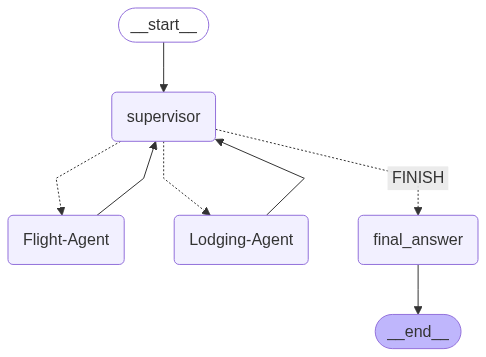

In [0]:
multi_agent

In [0]:
input_example = {
    "messages": [
        {
            "role": "user",
            "content": """I am accessible person and I'm planning a trip from Boston to San Diego from August 12th to August 20th. Can you help with both the flight and hotel parts of this trip?"""
        }
    ]
}
resp = AGENT.predict(input_example)

Trace(request_id=tr-717db299b12b4a38810dde9c4853ba08)

In [0]:
print(resp.messages[-1].content)

Based on your request, I've planned a trip from Boston to San Diego from August 12th to August 20th. Here are the details:

### Flight Information
- **Departure**: Boston Logan International Airport (BOS) on August 12th
- **Arrival**: San Diego International Airport (SAN) on August 12th
- **Return**: San Diego International Airport (SAN) on August 20th
- **Arrival Back to Boston**: Boston Logan International Airport (BOS) on August 20th
- **Flight Duration**: Approximately 5 hours from BOS to SAN
- **Airline**: American Airlines, which offers wheelchair assistance, priority boarding for passengers with disabilities, and accessible seating.
- **Flight Times**:
  - Departure from BOS: 8:00 AM EST
  - Arrival at SAN: 11:05 AM PST
  - Return from SAN: 2:00 PM PST
  - Arrival back at BOS: 9:05 PM EST
- **Prices**: Round-trip economy tickets start at $450. However, prices may vary based on the time of booking and availability.

### Hotel Information
- **Hotel Name**: Hotel Indigo San Diego G